In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

ImportError: Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Files path 

In [ ]:
train_path = "./titanic/train.csv"
test_path = "./titanic/test.csv"

# Somes definitions

In [ ]:
def load_data(file):
    return pd.read_csv(file)


In [ ]:
def preprocess(df):
    df = df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])

    categorical_features = df.select_dtypes(include=["object"]).columns.tolist()
    numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    age_features = ["Age"]

    age_pipeline = Pipeline([("imputer", KNNImputer()), ("scaler", MinMaxScaler())])

    cat_pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(drop="first")),
        ]
    )

    num_pipeline = Pipeline(
        [("imputer", SimpleImputer(strategy="mean")), ("scaler", MinMaxScaler())]
    )

    # Combine transformers into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", cat_pipeline, categorical_features),
            ("num", num_pipeline, numerical_features),
            ("age", age_pipeline, age_features),
        ]
    )

    preprocessed_df = preprocessor.fit_transform(df)

    feature_names = preprocessor.get_feature_names_out()

    # Convert the preprocessed data back to a DataFrame with the feature names
    preprocessed_df = pd.DataFrame(preprocessed_df, columns=feature_names)

    preprocessed_df = preprocessed_df.drop(columns=["num__Age"])

    return preprocessed_df

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# EDA

In [ ]:
dataset_train = load_data(train_path)
dataset_train.head()

dataset_test = load_data(test_path)

dataset_test.head()

NameError: name 'load_data' is not defined

## missing values ? 

In [ ]:
dataset_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
dataset_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Preprocessing

In [ ]:
df = preprocess(dataset_train)
df.head()

,cat__Sex_male,cat__Embarked_Q,cat__Embarked_S,num__Survived,num__Pclass,num__SibSp,num__Parch,num__Fare,age__Age
0,1.0,0.0,1.0,0.0,1.0,0.125,0.0,0.014151,0.271174
1,0.0,0.0,0.0,1.0,0.0,0.125,0.0,0.139136,0.472229
2,0.0,0.0,1.0,1.0,1.0,0.000,0.0,0.015469,0.321438
3,0.0,0.0,1.0,1.0,0.0,0.125,0.0,0.103644,0.434531
4,1.0,0.0,1.0,0.0,1.0,0.000,0.0,0.015713,0.434531


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df, df["num__Survived"], test_size=0.2, random_state=42
)
X_train = X_train.drop(columns=["num__Survived"])
X_test = X_test.drop(columns=["num__Survived"])

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
input_size = X_train.shape[1]

(712, 8)
(179, 8)
(712,)
(179,)


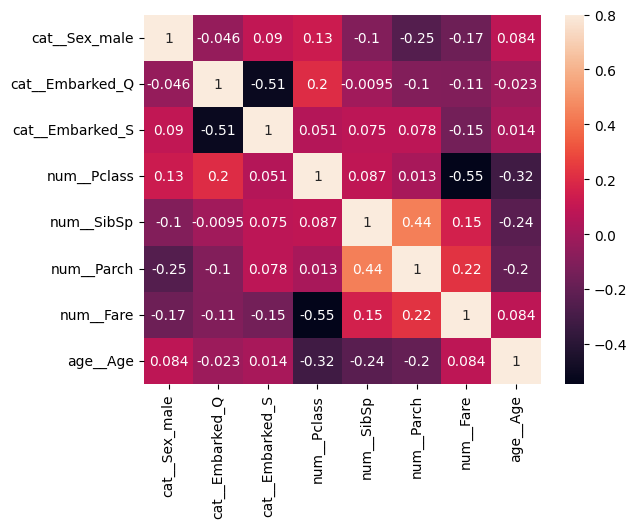

In [ ]:
sns.heatmap(X_train.corr(), vmax=0.8, annot=True)
plt.show()

# Model establishing

In [ ]:
model_parameters = {
    "epoch": 40,
    "batch_size": 2,
    "validation_split": 0.1,
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
    "loss": "binary_crossentropy",
    "optimizer": "adam",
    "metrics": ["accuracy"],
}

In [ ]:
model = tf.keras.Sequential()
model.add(Dense(50, input_shape=(input_size,)))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(
    loss=model_parameters["loss"],
    optimizer=model_parameters["optimizer"],
    metrics=model_parameters["metrics"],
)
history = model.fit(
    model_parameters["X_test"],
    model_parameters["y_test"],
    epochs=model_parameters["epoch"],
    batch_size=model_parameters["batch_size"],
    validation_split=model_parameters["validation_split"],
)

c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6336 - loss: 0.6462 - val_accuracy: 0.5000 - val_loss: 0.6382
Epoch 2/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6418 - loss: 0.5601 - val_accuracy: 0.6111 - val_loss: 0.5766
Epoch 3/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7713 - loss: 0.5312 - val_accuracy: 0.7222 - val_loss: 0.5382
Epoch 4/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7803 - loss: 0.5309 - val_accuracy: 0.7222 - val_loss: 0.5172
Epoch 5/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8015 - loss: 0.4844 - val_accuracy: 0.7778 - val_loss: 0.4574
Epoch 6/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8371 - loss: 0.4778 - val_accuracy: 0.8333 - val_loss: 0.4256
Epoch 7/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7714 - loss: 0.5640 - val_accuracy: 0.7778 - val_loss: 0.4383
Epoch 8/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8085 - loss: 0.4352 - val_accuracy: 0.7778 - val_loss

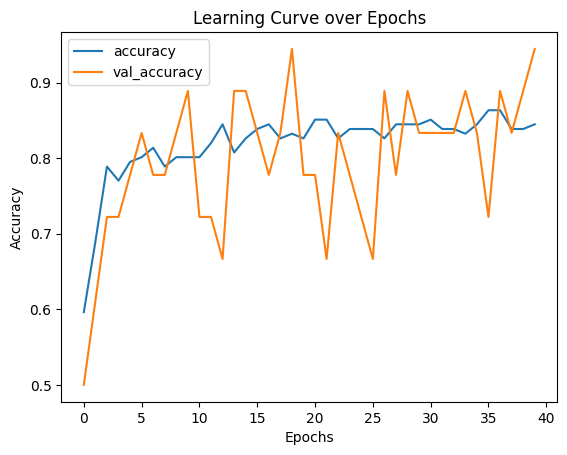

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Learning Curve over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["accuracy", "val_accuracy"], loc="upper left")
plt.show()